<h1>CNN + GRU</h1>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

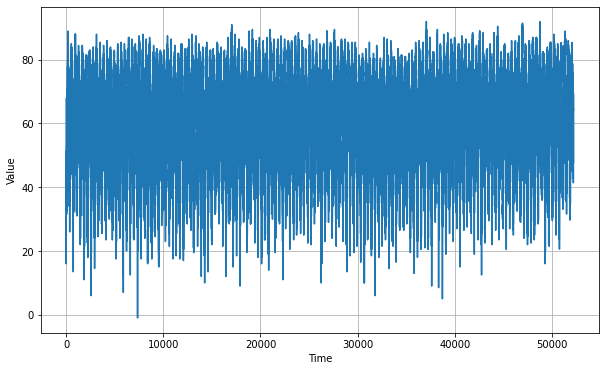

In [3]:
import csv
time_step = []
temps = []

with open('Birmingham-mean.csv') as csvfile:    
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [4]:
split_time = 40000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [6]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [8]:
window_size = 64
batch_size = 256
shuffle_buffer_size = 1000
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.GRU(100, input_shape=[None, 1], return_sequences=True),
  tf.keras.layers.GRU(100),  
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

model.compile(loss='mean_squared_error', optimizer='adam', metrics=["mae"])
history = model.fit(train_set, epochs=100, verbose=1)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(40000,)
Epoch 1/100
156/156 [==============================] - 26s 141ms/step - loss: 1345.0549 - mae: 30.0530
Epoch 2/100
156/156 [==============================] - 24s 155ms/step - loss: 109.4251 - mae: 8.3585
Epoch 3/100
156/156 [==============================] - 25s 158ms/step - loss: 66.2094 - mae: 6.2974
Epoch 4/100
156/156 [==============================] - 25s 157ms/step - loss: 66.1942 - mae: 6.2881
Epoch 5/100
156/156 [==============================] - 25s 157ms/step - loss: 65.9810 - mae: 6.2740
Epoch 6/100
156/156 [==============================] - 25s 158ms/step - loss: 65.9871 - mae: 6.2728
Epoch 7/100
156/156 [==============================] - 25s 158ms/step - loss: 65.9607 - mae: 6.2707
Epoch 8/100
156/156 [==============================] - 25s 158ms/step - loss: 65.9560 - mae: 6.2700
Epoch 9/100
156/156 [==============================] - 25s 158ms/step - loss: 65.9640 - mae: 

In [9]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
gru (GRU)                    (None, None, 100)         40200     
_________________________________________________________________
gru_1 (GRU)                  (None, 100)               60600     
_________________________________________________________________
dense_3 (Dense)              (None, 30)                3030      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                310       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 104,343
Trainable params: 104,343
Non-trainable params: 0
________________________________________________

In [11]:
def model_forecast(model, series, window_size):
    series = tf.expand_dims(series, axis=-1) 
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [14]:
forecast = model_forecast(model, series[split_time - window_size: -1], window_size)[:,0]

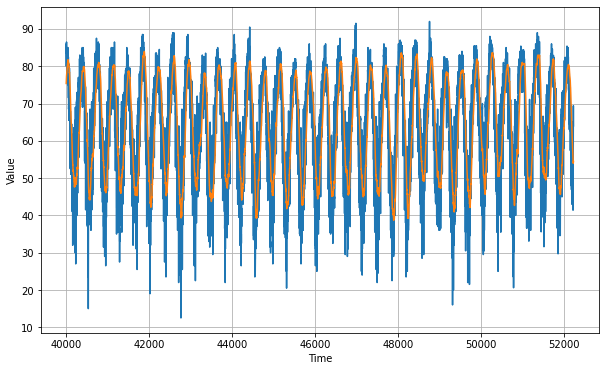

In [15]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)

In [16]:
tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()

7.746203

In [17]:
model.save('CNN_GRU_model.h5')

In [18]:
model = tf.keras.models.load_model('CNN_GRU_model.h5')